# EigenTorch Examples

In [49]:
import spdnn
import torch
import eigenfunctions as eF
import eigenoptim as eOptim
import matplotlib.pyplot as plt

In [152]:
## Generate Example features
s1 = 8
s2 = 3
Xdat = torch.rand(s1, s1)
X = Xdat @ Xdat.t()
tgt = torch.randn(s2, s2)
tgt = tgt @ tgt.t()
Wdat = torch.rand(s1, s1)
e, v = torch.eig(Wdat, eigenvectors=True)
Wdat = v[:s2]
W = spdnn.StiefelParameter(Wdat.clone().detach().requires_grad_(True))


## BiMap Example
___Demonstrate that output features are SPD and that weights remain semi-orthogonal after update.___

BiMap Output: 
	tensor([[ 2.5801,  1.6673, -0.2379],
        [ 1.6673,  2.4016, -0.2675],
        [-0.2379, -0.2675,  0.4595]], grad_fn=<BiMapBackward>)
Target: 
	tensor([[ 2.7355,  1.5045,  0.1669],
        [ 1.5045,  1.9002, -0.7454],
        [ 0.1669, -0.7454,  0.6719]])


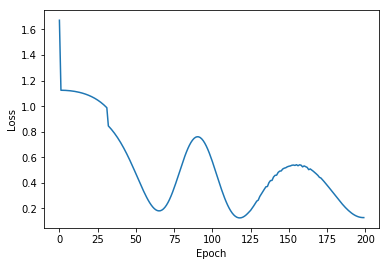

In [147]:
optim = eOptim.StiefelOpt([W], lr=0.0001)
bimap_func = eF.BiMap.apply
spd_arr = []
wne_arr = []
wor_arr = []
loss_arr = []
loss_e_arr = []

def check_spd(mat1):
    """
    check for spd by checking for positive norms of submatrices X[0:idx, 0:idx] where 0 < idx <= rank(X)
    Also check for symmetry.
    """
    result = True
    for idx in range(1, mat1.shape[0]):
        norm_val = mat1[:idx, :idx].norm()
        if norm_val <= 0.0:
            result = False
        for midx in range(idx, mat1.shape[0]):
            if (mat1[idx, midx] - mat1[midx, idx]) > 1e-4:
                result = False
    return result

def check_sortho(mat1):
    """
    Check to make sure matrix is semi-orthogonal 
    """
    tmat = mat1 @ mat1.t()
    idxs = torch.ones(3).diag() == 0
    valid = (tmat[idxs] < 1e-6).all()
    if not valid:
        print(tmat)
    return valid

# Loop through weight updates and check parameters and outputs
for epoch in range(200):
    W_old = W.clone().detach()
    # BiMap output and loss
    output = bimap_func(X, W)
    loss = torch.mean((output - tgt) **2)
    loss_arr.append(loss.item())
    loss.backward()
    optim.step()
    # Update Arrays for checking properties
    spd_arr.append(check_spd(output))
    wne_arr.append((W == W_old).sum() == 0)
    wor_arr.append(check_sortho(W))

# Ensure Parameters actually updated
assert(torch.tensor(wne_arr).all())
# Ensure updated Parameters are semi-orthogonal
assert(torch.tensor(wor_arr).all())
# Ensure Output is SPD
assert(torch.tensor(spd_arr).all())
# Plot Loss over time
plt.plot(loss_arr)
plt.plot(loss_e_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")
print("BiMap Output: \n\t{:s}".format(output.__repr__()))
print("Target: \n\t{:s}".format(tgt.__repr__()))
    
    



## ReEig Example: Demonstrate effect of eigenvalue thresholding by comparing against singular matrix

tensor([[ 1.5558e+01, -2.9987e-06, -3.9968e-06],
        [-3.1030e-06,  1.5558e+01,  6.6962e-06],
        [-3.0046e-06,  7.0448e-06,  1.5558e+01]], grad_fn=<MmBackward>)
tensor([[4.1190, 2.8646, 3.4983],
        [2.8646, 4.1491, 3.2978],
        [3.4983, 3.2978, 4.2984]], grad_fn=<BiMapBackward>)


Text(0, 0.5, 'Loss')

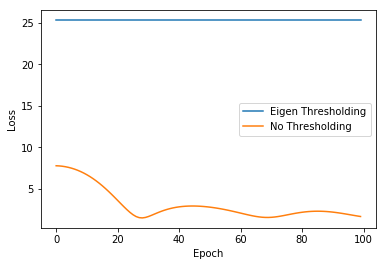

In [157]:
W2 = spdnn.StiefelParameter(W.clone().detach().requires_grad_(True))
min_eval = torch.eig(X)[0][:, 0][0].min()
loss_arr1 = []
loss_arr2 = []
optim = eOptim.StiefelOpt([W, W2], lr=0.0001)

for epoch in range(100):
    output1 = eF.ReEig(bimap_func(X, W), min_eval - 1e-4)
    loss1 = (output1 - torch.ones_like(output1)).norm()
    loss_arr1.append(loss1.item())
    loss1.backward()
    output2 = bimap_func(X, W2)
    loss2 = (output2 - torch.ones_like(output2)).norm()
    loss_arr2.append(loss2.item())
    loss2.backward()
    if epoch == 0:
        print(output1)
        print(output2)
    optim.step()
plt.plot(loss_arr1)
plt.plot(loss_arr2)
plt.legend(['Eigen Thresholding', 'No Thresholding'])
plt.xlabel('Epoch')
plt.ylabel('Loss')